## By: Nicolas Acha

In [60]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


In [61]:
#open user_table
users_ = pd.read_csv('00_user_table.csv')
df= users_

#open rest
home_pg = pd.read_csv('01_home_page_table.csv')
search_pg = pd.read_csv('02_search_page_table.csv')
payment_pg = pd.read_csv('03_payment_page_table.csv')
confirmation_pg = pd.read_csv('04_payment_confirmation_table.csv')

#flag each step in the funnel
pgs = {
    'home': home_pg,
    'search': search_pg,
    'payment': payment_pg,
    'confirmation': confirmation_pg
}

for i,df_all in pgs.items():
    df[f'{i}_pg'] = df['user_id'].isin(df_all['user_id']).astype(int)



#modify column "date" to "user_created_at"
df.rename(columns={'date':'user_created_at'},inplace=True)
df['user_created_at'] = pd.to_datetime(df['user_created_at'])

#look if duplicates user_id values -> None 
#duplicated_user = users_[users_.duplicated(keep=False)]
#duplicated_user

#order df by user_created_at and by payment_confirmation
df = df.sort_values(by=['confirmation_pg', 'user_created_at'], ascending=[False, True])
df.to_csv('x.csv')


# CHECKS

In [62]:
df_checks =df.copy()
df_checks['checks'] = df_checks[['home_pg', 'search_pg', 'payment_pg', 'confirmation_pg']].sum(axis=1)

#check all rows make sense 
# Define the conditions for flagging

def check_rules(row):
    if row['confirmation_pg'] == 1 and row['checks'] != 4:
        return 'Flag'
    elif row['payment_pg'] == 1 and row['confirmation_pg'] == 0 and row['checks'] != 3:
        return 'Flag'
    elif row['search_pg'] == 1 and row['payment_pg'] == 0 and row['checks'] != 2:
        return 'Flag'
    return ''

# Apply the conditions to create the flag column
df_checks['Flag'] = df_checks.apply(check_rules, axis=1)
df_checks = df_checks[df_checks['Flag'] != '']
df_checks

#All rows make sense, no duplicate users id. 



,user_id,user_created_at,device,sex,home_pg,search_pg,payment_pg,confirmation_pg,checks,Flag


In [63]:
df.info()
#no nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 15089 to 90339
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          90400 non-null  int64         
 1   user_created_at  90400 non-null  datetime64[ns]
 2   device           90400 non-null  object        
 3   sex              90400 non-null  object        
 4   home_pg          90400 non-null  int32         
 5   search_pg        90400 non-null  int32         
 6   payment_pg       90400 non-null  int32         
 7   confirmation_pg  90400 non-null  int32         
dtypes: datetime64[ns](1), int32(4), int64(1), object(2)
memory usage: 4.8+ MB


# EDA: Exploratory Data Analysis

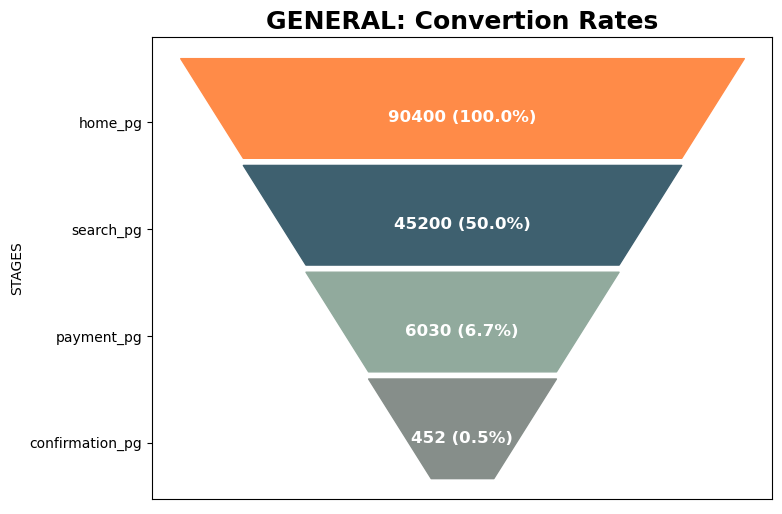

In [64]:
#GENERAL CONVERTION RATES (CR from home to stage)

stages = ['home_pg', 'search_pg', 'payment_pg', 'confirmation_pg']
values = [df[step].sum() for step in stages]
total_users = df["user_id"].nunique()

funnel_df = pd.DataFrame({"Stages": stages, "Values": values})
percentages = [(value / total_users) * 100 for value in funnel_df["Values"]]


colors = ["#868e8a", "#91AA9D", "#3E606F", "#ff8b48"]

fig = plt.figure(figsize=(8,6))


for y, value, pct in zip([2, 5, 8, 11], funnel_df["Values"][::-1], percentages[::-1]):
    plt.text(9, y, f"{value} ({pct:.1f}%)", fontsize=12, fontweight="bold", color="white", ha="center")

plt.fill_betweenx(y=[1, 3.8], x1=[10,12], x2=[8,6], color=colors[0])
plt.fill_betweenx(y=[4, 6.8], x1=[12,14], x2=[6,4], color=colors[1])
plt.fill_betweenx(y=[7, 9.8], x1=[14,16], x2=[4,2], color=colors[2])
plt.fill_betweenx(y=[10, 12.8], x1=[16,18], x2=[2,0], color=colors[3])
plt.xticks([],[]);
plt.yticks([2,5,8,11], funnel_df["Stages"][::-1])
plt.ylabel("STAGES")
plt.title("GENERAL: Convertion Rates", loc="center", fontsize=18, fontweight="bold")
stages = ['home_pg', 'search_pg', 'payment_pg', 'confirmation_pg']
values = [df[step].sum() for step in stages]
funnel_df = pd.DataFrame({"Stages": stages, "Values": values})
plt.show()

The General CR of the company for this day of operations is 0.5% 
--------------------------------------------
Half of the users do not pass beyond the home page
From those who use the search page less than 15% go over payment page
Finally, only 7% of users end up really completing a purchase


Let's explore if there is an unbalaced pattern with gender and / or device users 

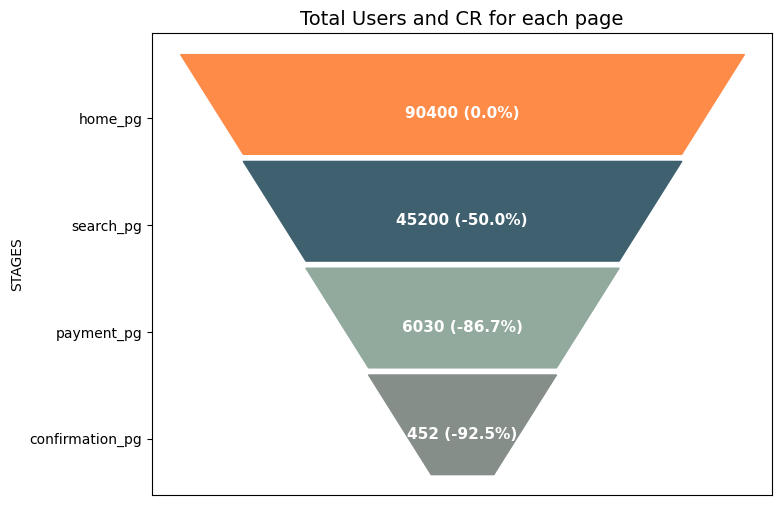

In [65]:
#(CR from PREVIOUS stage to CURRENT stage)

stages = ['home_pg', 'search_pg', 'payment_pg', 'confirmation_pg']
values = [df[step].sum() for step in stages]
total_users = df["user_id"].nunique()

funnel_df = pd.DataFrame({"Stages": stages, "Values": values})


variation_pct = [0] + [(funnel_df["Values"].iloc[i] - funnel_df["Values"].iloc[i - 1]) / funnel_df["Values"].iloc[i - 1] * 100
                       for i in range(1, len(funnel_df["Values"]))]

colors = ["#868e8a", "#91AA9D", "#3E606F", "#ff8b48"]

fig = plt.figure(figsize=(8,6))

for y, value, var_pct in zip([2, 5, 8, 11], funnel_df["Values"][::-1], variation_pct[::-1]):
    plt.text(9, y, f"{value} ({var_pct:.1f}%)", fontsize=11, fontweight="bold", color="white", ha="center")


plt.fill_betweenx(y=[1, 3.8], x1=[10,12], x2=[8,6], color=colors[0])
plt.fill_betweenx(y=[4, 6.8], x1=[12,14], x2=[6,4], color=colors[1])
plt.fill_betweenx(y=[7, 9.8], x1=[14,16], x2=[4,2], color=colors[2])
plt.fill_betweenx(y=[10, 12.8], x1=[16,18], x2=[2,0], color=colors[3])
plt.xticks([],[])
plt.yticks([2,5,8,11], funnel_df["Stages"][::-1])
plt.ylabel("STAGES")
plt.title("Total Users and CR for each page", loc="center", fontsize=14)
plt.show()



In [66]:

def plot_funnel(ax, df, title):
    
    stages = ['home_pg', 'search_pg', 'payment_pg', 'confirmation_pg']
    values = [df[step].sum() for step in stages]
    total_users = df["user_id"].nunique()
    #percentages = [(value / total_users) * 100 for value in values]
    

    funnel_df = pd.DataFrame({"Stages": stages, "Values": values})
    
    # Calculate percentage of variation between stages
    variation_pct = [0] + [(funnel_df["Values"].iloc[i] - funnel_df["Values"].iloc[i - 1]) / funnel_df["Values"].iloc[i - 1] * 100
                    for i in range(1, len(funnel_df["Values"]))]
    

    colors = ["#888888", "#445058", "#3A444A", "#293136"]
    
    for y, value, pct in zip([2, 5, 8, 11], funnel_df["Values"][::-1], variation_pct[::-1]):
        ax.text(9, y, f"{value} ({pct:.1f}%)", fontsize=10, fontweight="bold", color="white", ha="center")
        
    ax.fill_betweenx(y=[1, 3.8], x1=[10,12], x2=[8,6], color=colors[0])
    ax.fill_betweenx(y=[4, 6.8], x1=[12,14], x2=[6,4], color=colors[1])
    ax.fill_betweenx(y=[7, 9.8], x1=[14,16], x2=[4,2], color=colors[2])
    ax.fill_betweenx(y=[10, 12.8], x1=[16,18], x2=[2,0], color=colors[3])
    ax.set_xticks([])
    ax.set_yticks([2, 5, 8, 11])
    ax.set_yticklabels(funnel_df["Stages"][::-1])
    ax.set_ylabel("STAGES")
    ax.set_title(title, loc="center", fontsize=12, fontweight="bold")


In [67]:
df_female = df[df['sex'] == 'Female']
df_male = df[df['sex'] == 'Male']
df_mobile = df[df['device'] == 'Mobile']
df_desktop = df[df['device'] == 'Desktop']

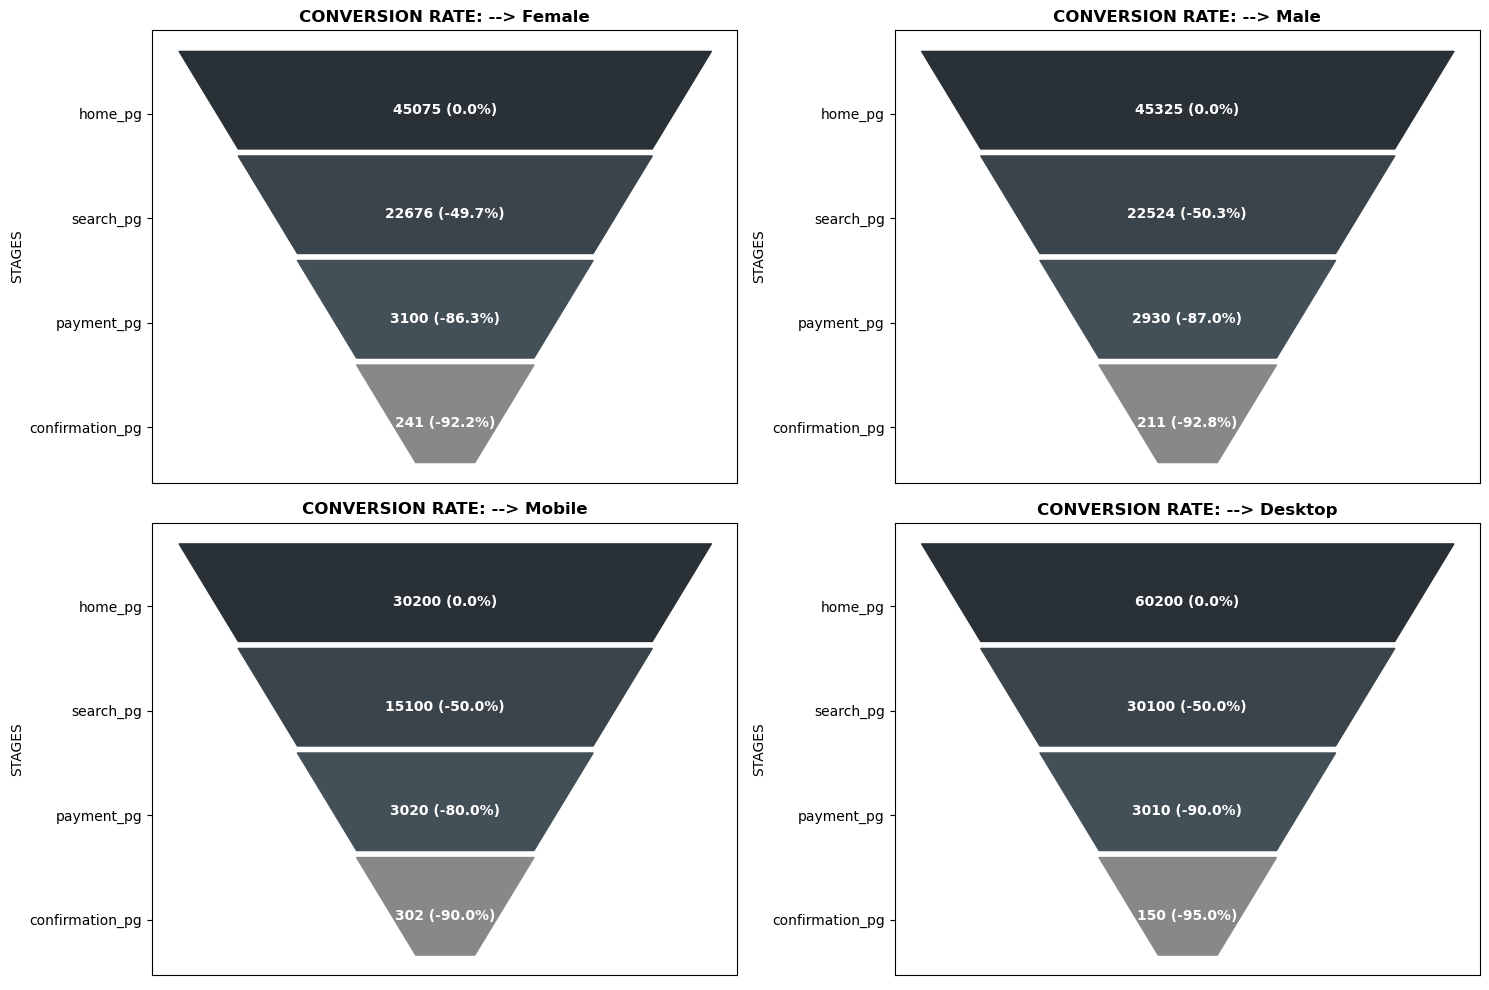

In [68]:
#CR (CR from PREVIOUS stage to CURRENT stage) FUNNEL FEMALE VS. MALE and MOBILE VS. DESKTOP
#Plotting grid 2x2
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plot_info = {
    (0, 0): (df_female, 'CONVERSION RATE: --> Female'),
    (0, 1): (df_male, 'CONVERSION RATE: --> Male'),
    (1, 0): (df_mobile, 'CONVERSION RATE: --> Mobile'),
    (1, 1): (df_desktop, 'CONVERSION RATE: --> Desktop')
}

for (i, j), (df_segment, title) in plot_info.items():
    plot_funnel(axes[i, j], df_segment, title)

plt.tight_layout()
plt.show()

In [69]:
#CR (CR from PREVIOUS stage to CURRENT stage) BY DEVISE and GENDER 
def plot_funnel(ax, df, title):
    
    stages = ['home_pg', 'search_pg', 'payment_pg', 'confirmation_pg']
    values = [df[step].sum() for step in stages]
    total_users = df["user_id"].nunique()
    #percentages = [(value / total_users) * 100 for value in values]
    

    funnel_df = pd.DataFrame({"Stages": stages, "Values": values})
    
    # Calculate percentage of variation between stages
    variation_pct = [0] + [(funnel_df["Values"].iloc[i] - funnel_df["Values"].iloc[i - 1]) / funnel_df["Values"].iloc[i - 1] * 100
                    for i in range(1, len(funnel_df["Values"]))]
    

    colors = ["#888888", "#445058", "#3A444A", "#293136"]
    
    for y, value, pct in zip([2, 5, 8, 11], funnel_df["Values"][::-1], variation_pct[::-1]):
        ax.text(9, y, f"{value} ({pct:.1f}%)", fontsize=10, fontweight="bold", color="white", ha="center")

    ax.fill_betweenx(y=[1, 3.8], x1=[10,12], x2=[8,6], color=colors[0])
    ax.fill_betweenx(y=[4, 6.8], x1=[12,14], x2=[6,4], color=colors[1])
    ax.fill_betweenx(y=[7, 9.8], x1=[14,16], x2=[4,2], color=colors[2])
    ax.fill_betweenx(y=[10, 12.8], x1=[16,18], x2=[2,0], color=colors[3])
    ax.set_xticks([])
    ax.set_yticks([2, 5, 8, 11])
    ax.set_yticklabels(funnel_df["Stages"][::-1])
    ax.set_ylabel("STAGES")
    ax.set_title(title, loc="center", fontsize=12, fontweight="bold")

In [70]:
df_female_mobile = df[(df['sex'] == 'Female') & (df['device'] == 'Mobile')]
df_female_desktop = df[(df['sex'] == 'Female') & (df['device'] == 'Desktop')]
df_male_mobile = df[(df['sex'] == 'Male') & (df['device'] == 'Mobile')]
df_male_desktop = df[(df['sex'] == 'Male') & (df['device'] == 'Desktop')]

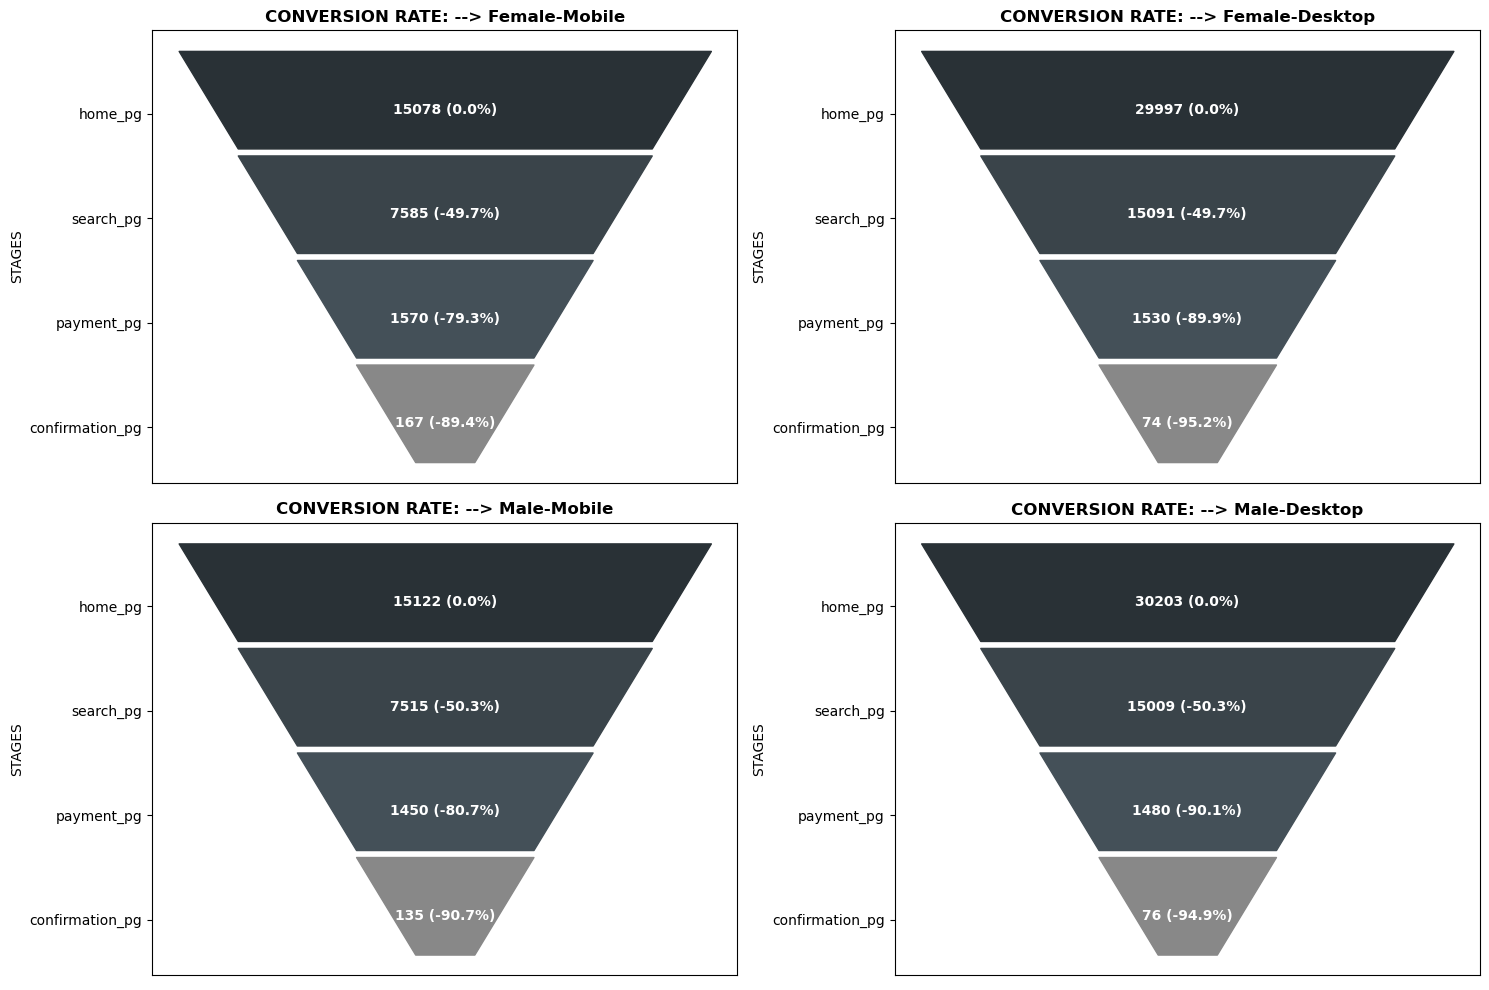

In [71]:
# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

plot_info = {
    (0, 0): (df_female_mobile, 'CONVERSION RATE: --> Female-Mobile'),
    (0, 1): (df_female_desktop, 'CONVERSION RATE: --> Female-Desktop'),
    (1, 0): (df_male_mobile, 'CONVERSION RATE: --> Male-Mobile'),
    (1, 1): (df_male_desktop, 'CONVERSION RATE: --> Male-Desktop')
}

for (i, j), (df_segment, title) in plot_info.items():
    plot_funnel(axes[i, j], df_segment, title)

plt.tight_layout()
plt.show()

NOTE OBSERVED: The proportion of Female/Male users is very symmetric 
Desktop users double the population of mobile users although mobile convertion dobles the desktop one

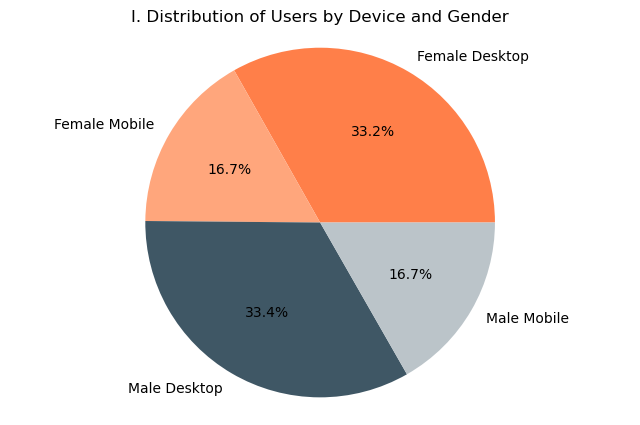

In [72]:
#Pie chart

total_counts = df.groupby([ 'sex','device']).size()
total_counts = total_counts.reset_index(name='count')
labels = total_counts.apply(lambda row: f"{row['sex']} {row['device']}", axis=1)
sizes = total_counts['count']
colors = ["#ff7f49","#ffa67c", "#3f5765",  "#bbc4c9"]
plt.figure(figsize=(8, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)
plt.title('I. Distribution of Users by Device and Gender')
plt.axis('equal')
plt.show()


NOTE OBSERVED: Very balanced user distribution among genders, with a population of Desktop users being twice as large compared to Mobile

C:\Users\Nico\AppData\Local\Temp\ipykernel_25184\2452095048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['year_month'] = purchases['user_created_at'].dt.to_period('M')


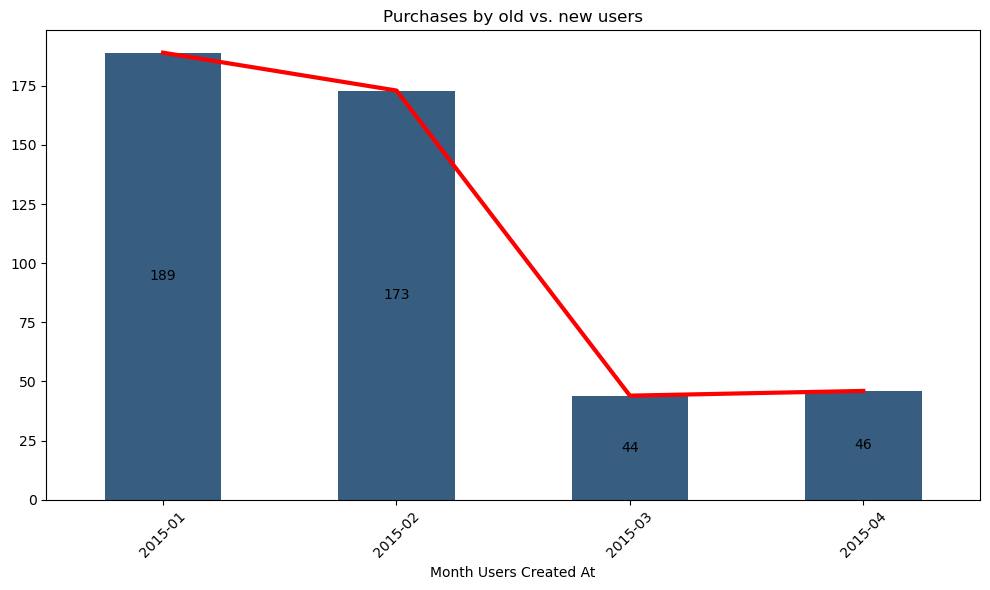

In [73]:
#Purchases older vs. newer users 

purchases = df[df['confirmation_pg'] == 1]
purchases['year_month'] = purchases['user_created_at'].dt.to_period('M')
monthly_counts = purchases['year_month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
counta = monthly_counts.plot(kind='bar', color='#375D81')
counta.bar_label(counta.containers[0],label_type='center')


#trend line sector
x = np.arange(len(monthly_counts))
plt.plot(x, monthly_counts.values, color='red', linestyle='solid', marker='', linewidth=3)

#plot
plt.xlabel('Month Users Created At')
plt.title('Purchases by old vs. new users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


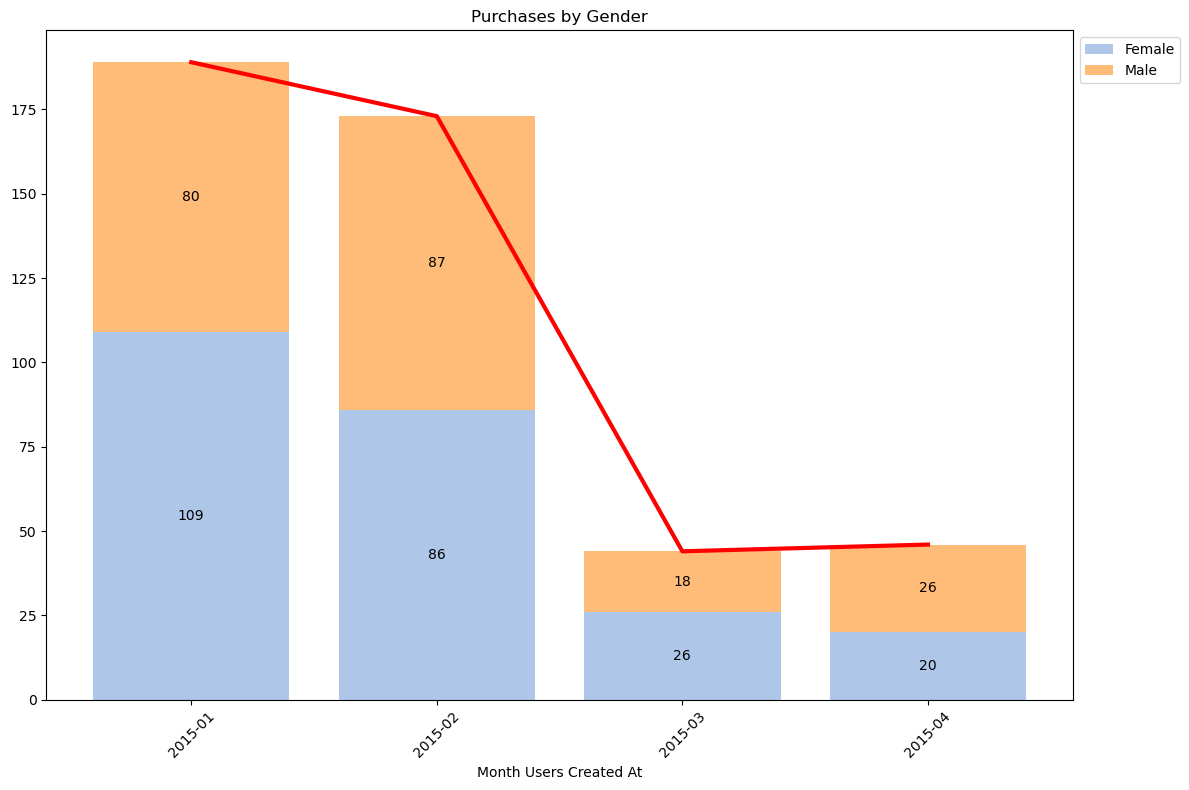

In [74]:
counts = purchases.groupby(['year_month', 'sex']).size().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
#stackup
colors = {'Female': '#aec7e8', 'Male': '#ffbb78'}
bottom_values = np.zeros(len(counts))
for gender in counts.columns:
    ax.bar(counts.index.astype(str), counts[gender], 
           color=colors[gender], bottom=bottom_values, label=gender)
    bottom_values += counts[gender]

#trend line sector
x = np.arange(len(counts.index))
total_counts = counts.sum(axis=1)
ax.plot(x, total_counts, color='red', linestyle='solid', marker='', linewidth=3)

#labels
for container in ax.containers:
    ax.bar_label(container, label_type='center')

ax.set_xlabel('Month Users Created At')
ax.set_title('Purchases by Gender')
ax.set_xticks(range(len(counts.index)))
ax.set_xticklabels(counts.index.astype(str), rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


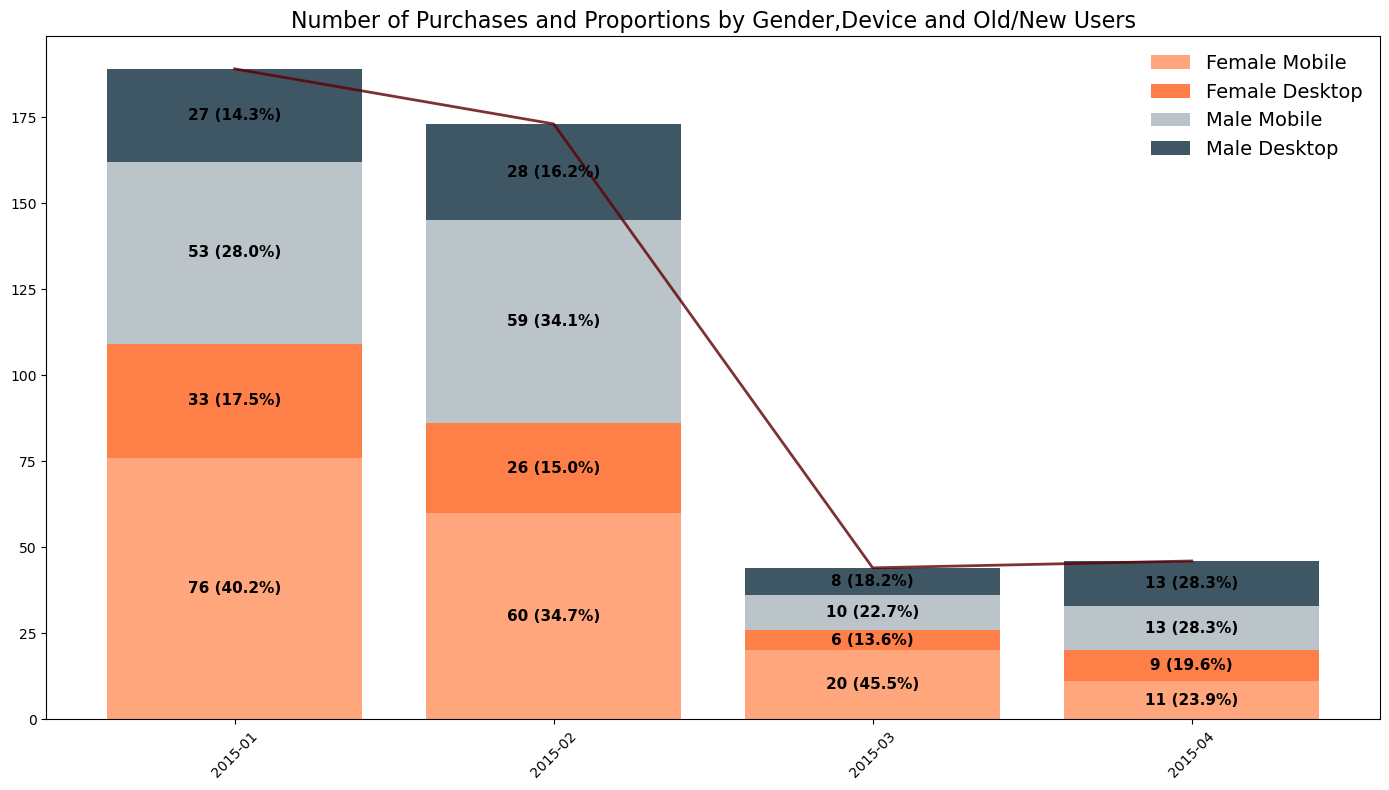

In [75]:
counts = purchases.groupby(['year_month', 'sex', 'device']).size().unstack(level=['sex', 'device'], fill_value=0)

fig, ax = plt.subplots(figsize=(14, 8))

colors = {
    ('Female', 'Mobile'): '#ffa67c',
    ('Female', 'Desktop'): '#ff7f49',
    ('Male', 'Mobile'): '#bbc4c9',
    ('Male', 'Desktop'): '#3f5765'
}
#stackup
bottom_values = np.zeros(len(counts))
for (gender, device), color in colors.items():
    if (gender, device) in counts.columns:
        bar_container = ax.bar(counts.index.astype(str), counts[(gender, device)], 
                               color=color, bottom=bottom_values, label=f'{gender} {device}')
        bottom_values += counts[(gender, device)]
        

#trend line sector
x = np.arange(len(counts.index))
total_counts = counts.sum(axis=1)
ax.plot(x, total_counts, color='#5C0002', linestyle='solid', marker='', linewidth=2, alpha=0.8)

#labels
total_counts = counts.sum(axis=1)
for i, month in enumerate(counts.index):
    cumulative_bottom = 0
    for (gender, device), color in colors.items():
        if (gender, device) in counts.columns:
            height = counts[(gender, device)].iloc[i]
            if height > 0:
                x = i
                y = cumulative_bottom + height / 2
                percentage = (height / total_counts[month]) * 100
                ax.text(x, y, f'{height} ({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=11, fontweight='bold')  
            cumulative_bottom += height

#ax.set_xlabel('Month Users Created At')
ax.set_title('Number of Purchases and Proportions by Gender,Device and Old/New Users',fontsize=16)
ax.set_xticks(range(len(counts.index)))
ax.set_xticklabels(counts.index.astype(str), rotation=45)
ax.legend(loc='upper right', frameon=False,fontsize=14)
plt.tight_layout()
plt.show()



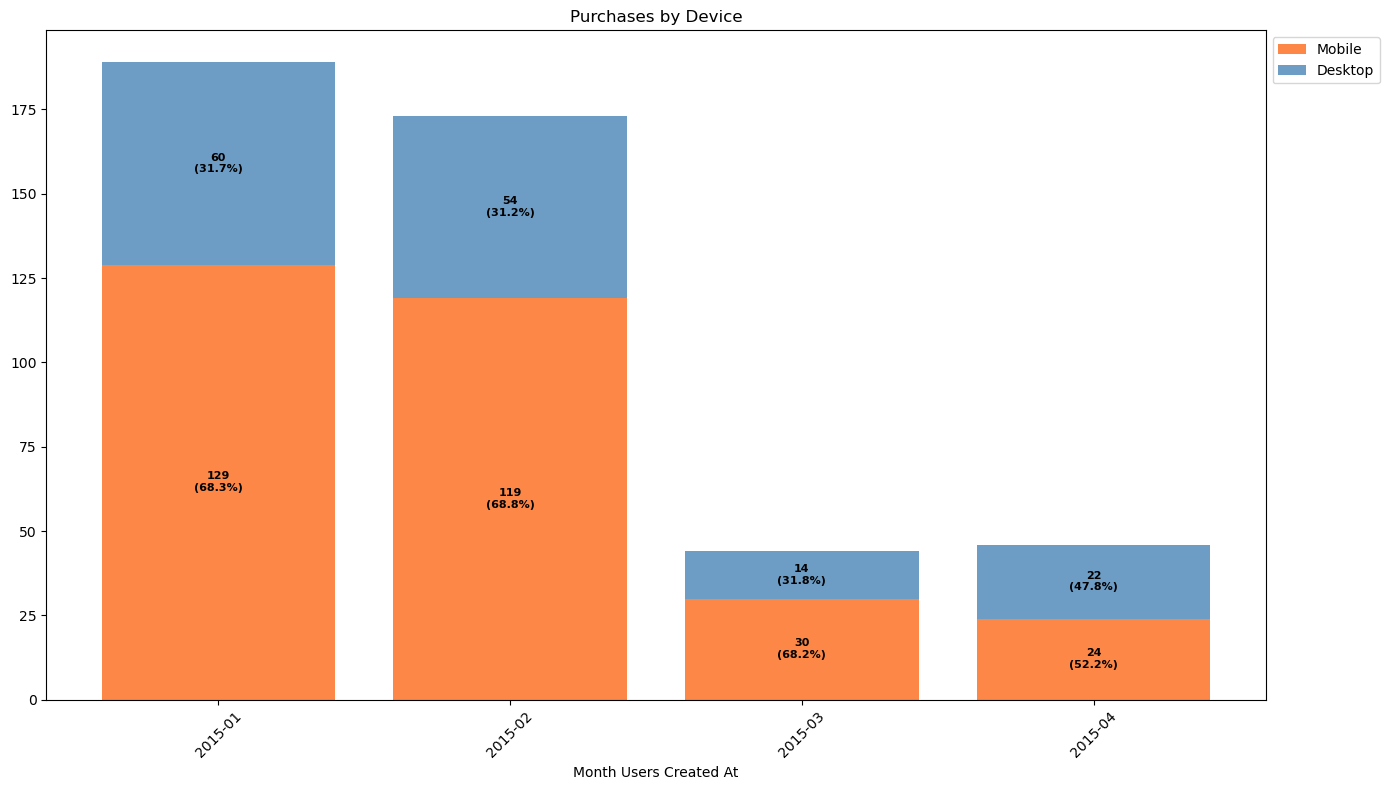

In [76]:
counts = purchases.groupby(['year_month', 'device']).size().unstack(level='device', fill_value=0)

fig, ax = plt.subplots(figsize=(14, 8))

# Define colors
colors = {
    'Mobile': '#fc8747',    # Light blue for Mobile
    'Desktop': '#6d9dc5'     # Light blue for Desktop
}

#stackup
bottom_values = np.zeros(len(counts))
for device, color in colors.items():
    if device in counts.columns:
        bar_container = ax.bar(counts.index.astype(str), counts[device], 
                               color=color, bottom=bottom_values, label=f'{device}')
        bottom_values += counts[device]

#labels
total_counts = counts.sum(axis=1)
for i, month in enumerate(counts.index):
    cumulative_bottom = 0
    for device, color in colors.items():
        if device in counts.columns:
            height = counts[device].iloc[i]
            if height > 0:
                x = i
                y = cumulative_bottom + height / 2
                percentage = (height / total_counts[month]) * 100
                ax.text(x, y, f'{height}\n({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=8, fontweight='bold')
            cumulative_bottom += height

# Format the plot
ax.set_xlabel('Month Users Created At')
ax.set_title('Purchases by Device')
ax.set_xticks(range(len(counts.index)))
ax.set_xticklabels(counts.index.astype(str), rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


NOTE OBSERVED: Confirmed that new ussers where they exists after february 2015 tend to purchase less. Would it be because of proportions? 


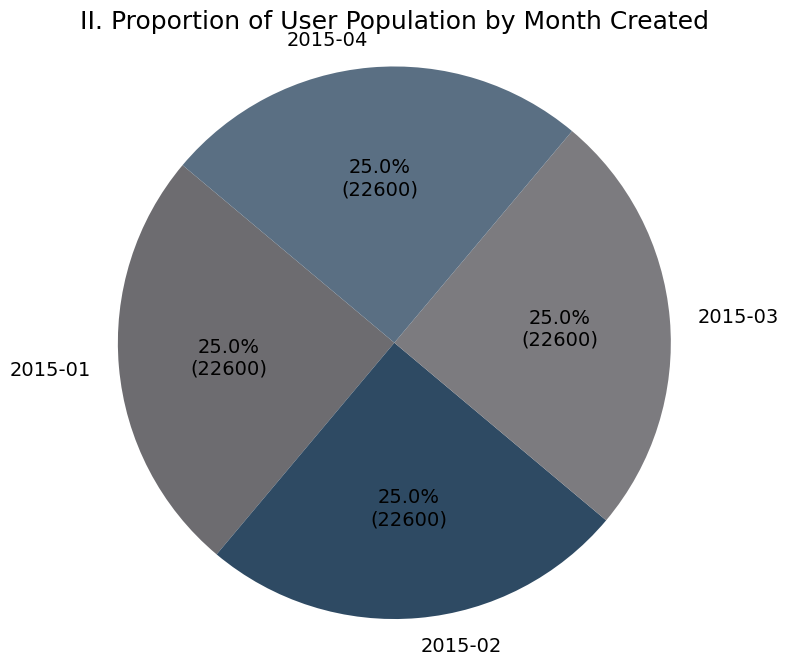

In [77]:
monthly_counts = df['user_created_at'].dt.to_period('M').value_counts().sort_index()

#custom labels
def func(pct, all_values):
    absolute = int(pct / 100. * sum(all_values))
    return f'{pct:.1f}%\n({absolute})'


colors = ["#6D6C70","#2E4A63","#7c7b7f","#5a6f83",]
          
plt.figure(figsize=(8, 8))
plt.pie(monthly_counts, labels=monthly_counts.index.astype(str), autopct=lambda pct: func(pct, monthly_counts),colors=colors, startangle=140,textprops={'fontsize': 14})
plt.title('II. Proportion of User Population by Month Created',fontsize=18)
plt.axis('equal')
plt.show()

Each month we have exactly the same amounth of users created lets check their funel rates